<a href="https://colab.research.google.com/github/rohandawar/Databricks/blob/main/Irirs_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am trying to classify the iris dataset

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=50a8665781c1c6a742196cc863247434718997095ce9169cce56dc5caba35e9f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# import libs
# sklearn
from sklearn.datasets import load_iris

# Pandas
import pandas as pd
import numpy as np

# Pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Create a spark session
spark = SparkSession.builder.appName('DecisionTreeClassifier').getOrCreate()

In [ ]:
# load the data
iris = load_iris()

# Read the data as pandas df
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['Target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


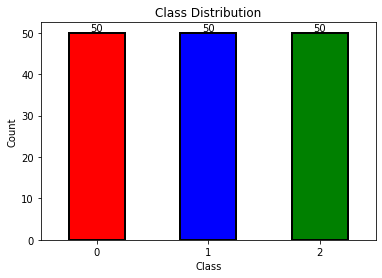

In [ ]:
# Get the class distributions
class_counts = df['Target'].value_counts()

# Sort the classes based on count
class_counts = class_counts.sort_values(ascending=False)

# Define colors for each class
colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot class distribution using a bar chart
ax = class_counts.plot(kind='bar', color=[colors[i] for i in class_counts.index], edgecolor='black', linewidth=2)

# Add data labels to each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            int(height), ha='center', va='bottom')

# Add title & Lables
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Rotate x-axis labels
plt.xticks(rotation=360)

# Show plot
plt.show()

In [ ]:
# Convert Pandas df to spark df
spark_df = spark.createDataFrame(df)
spark_df.head(1)

[Row(sepal length (cm)=5.1, sepal width (cm)=3.5, petal length (cm)=1.4, petal width (cm)=0.2, Target=0)]

In [ ]:
# perform the train & test split
train_df, test_df = spark_df.randomSplit([0.8,0.2], seed=123)

In [ ]:
# Assemeble all the features into a single column
Assembler = VectorAssembler(inputCols=iris.feature_names, outputCol = 'features')

# Fit the assembler
train_df = Assembler.transform(train_df)
test_df = Assembler.transform(test_df)

In [ ]:
# Instaiate a Decision Tree Model
dt = DecisionTreeClassifier(labelCol='Target', featuresCol='features')

In [ ]:
from pyspark.ml import evaluation
# Create a grid of HyperParameters
params_grid = ParamGridBuilder()\
              .addGrid(dt.maxDepth, [3,5,10])\
              .addGrid(dt.impurity, ['gini', 'entropy'])\
              .build()

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Target')


In [ ]:
# Use Cross Validator to tune the hyper-Parameters
cv = CrossValidator(estimator=dt, estimatorParamMaps=params_grid, evaluator=evaluator, numFolds=10)

# Fit the model in training data
model = cv.fit(train_df)


# Extract the best fitted model from the CrossValidator
best_Model = model.bestModel


In [ ]:
# Checking the best model
best_Model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_78a9dab0cb4c, depth=3, numNodes=7, numClasses=3, numFeatures=4

In [ ]:
# Make Predictions 
predictions = best_Model.transform(test_df)

In [ ]:
# Evaluate the models performance
accuracy = evaluator.evaluate(predictions)
print('Accuracy:', accuracy)

Accuracy: 1.0
